## Providing data-driven suggestions for HR in Salifort Motors

### Problem Statement

Employee attrition at Salifort Motors has been a problem that needed immediate attention at Salfort Motors and the HR department wants to take some initiatives to improve employee satisfaction. 

Q: What's likely to make the employee leave the company? (based on data)

Goal: It is to analyze the data collected by the HR department and to build a model that predicts whether or not an employee will levae the company

### Understanding the Data

In this [dataset](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv), there are 14,999 rows, 10 columns, and these variables: 

Variable  |Description |
-----|-----| 
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

In [129]:
# import packages

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Displaying all the columns of the dataframe
pd.set_option('display.max_columns', None)

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import XGBRegressor

# Metrics and helpful functions
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.tree import plot_tree

# Saving models
import pickle

In [130]:
# Reading the data

df0 = pd.read_csv('Data/Salfort_HR_comma_sep.csv')
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [131]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [132]:
# There are no missing values in the dataset, total 14999 rows and 10 columns

df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [133]:
# Renaming the columns if needed(snake_case, spellings, etc.)
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [134]:
df0 = df0.rename(columns={'Work_accident': 'work_accident', 
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'})

df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [135]:
df0.duplicated().sum()

3008

In [136]:
# Duplicate rows are removed and the dataset is saved as df1
df1 = df0.drop_duplicates(keep='first')
df1.duplicated().sum()

0

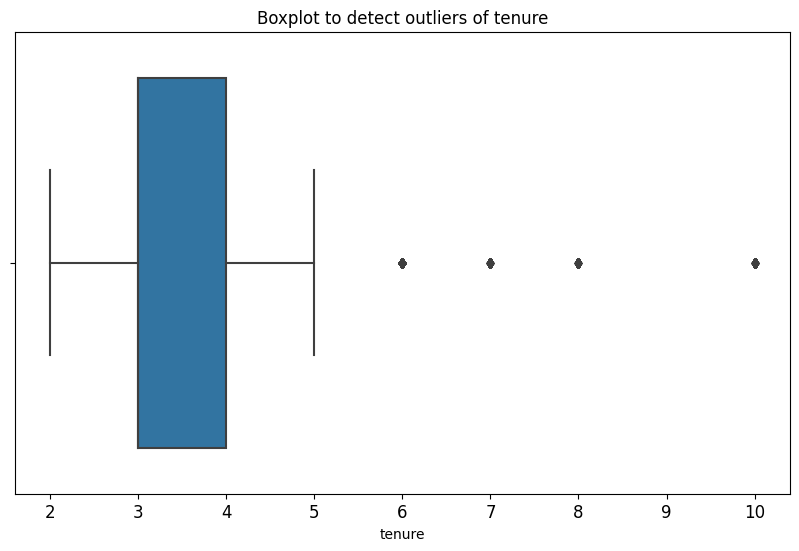

In [137]:
# Checking for outliers in tenure
plt.figure(figsize=(10, 6))
plt.title('Boxplot to detect outliers of tenure', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df1.tenure)
plt.show()

In [138]:
# Calculating the number of rows containing outliers

percentile25 = df1.tenure.quantile(0.25)
percentile75 = df1.tenure.quantile(0.75)

iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower Limit: ", lower_limit)
print("Upper Limit: ", upper_limit)

outliers = df1[(df1.tenure < lower_limit) | (df1.tenure > upper_limit)]

print("Number of rows in the dataset containing outliers: ", outliers.shape[0])

Lower Limit:  1.5
Upper Limit:  5.5
Number of rows in the dataset containing outliers:  824


## Exploratory Data Analysis

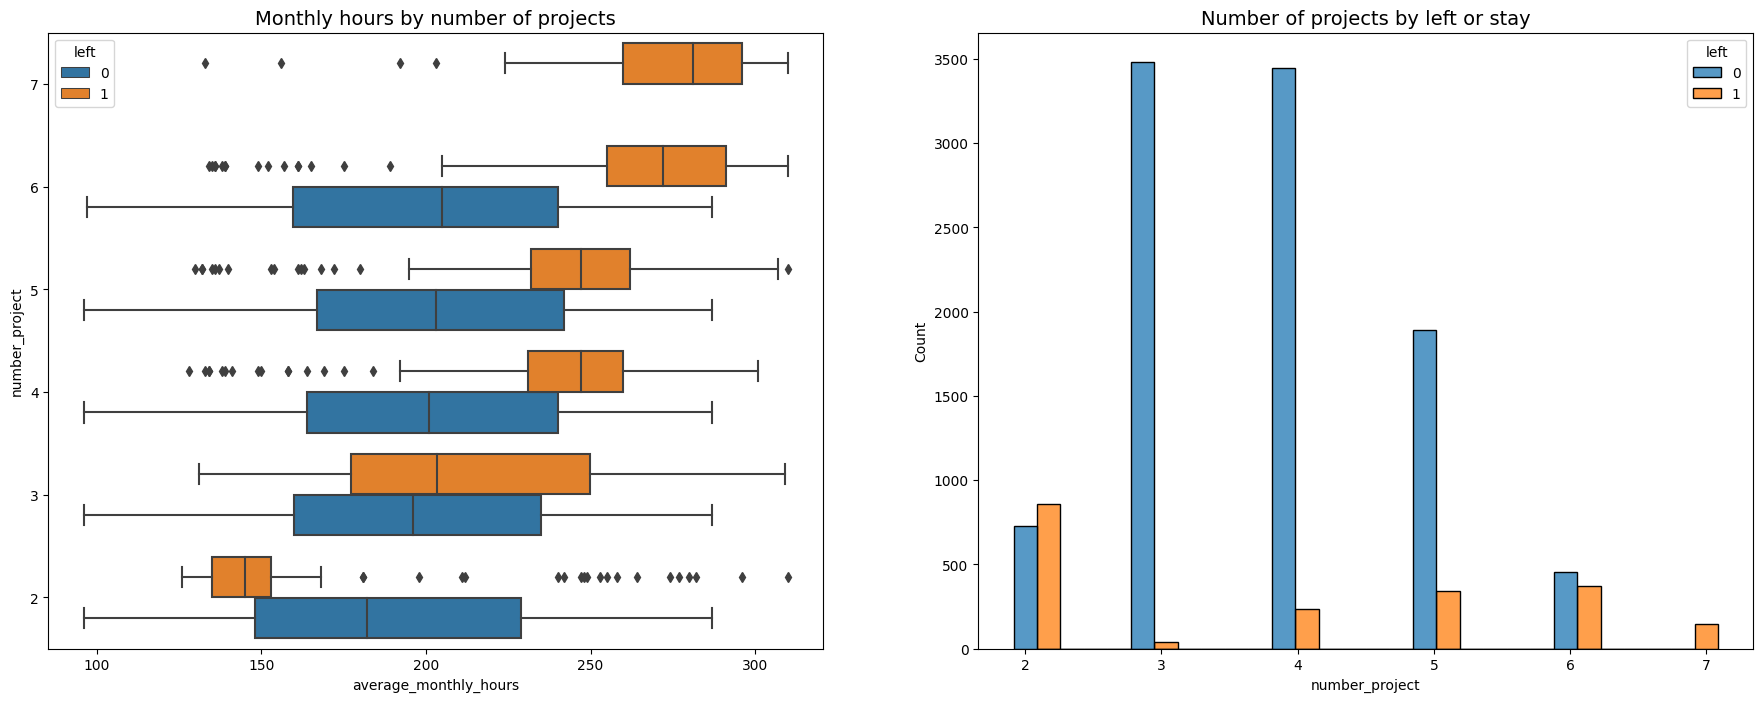

In [139]:
fig, ax = plt.subplots(1,2, figsize = (22,8))

sns.boxplot(data=df1, x='average_monthly_hours', y='number_project', hue='left',
            orient='h', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')

tenure_stay = df1[df1['left'] == 0]['number_project']
tenure_left = df1[df1['left'] == 1]['number_project']
sns.histplot(data=df1, x='number_project', hue='left',  multiple='dodge', 
             shrink=2, ax=ax[1])
ax[1].set_title('Number of projects by left or stay', fontsize='14')

plt.show()

In [140]:
df1[df1['number_project']==7]['left'].value_counts()

left
1    145
Name: count, dtype: int64

Text(0.5, 1.0, 'Average monthly hours vs. satisfaction level')

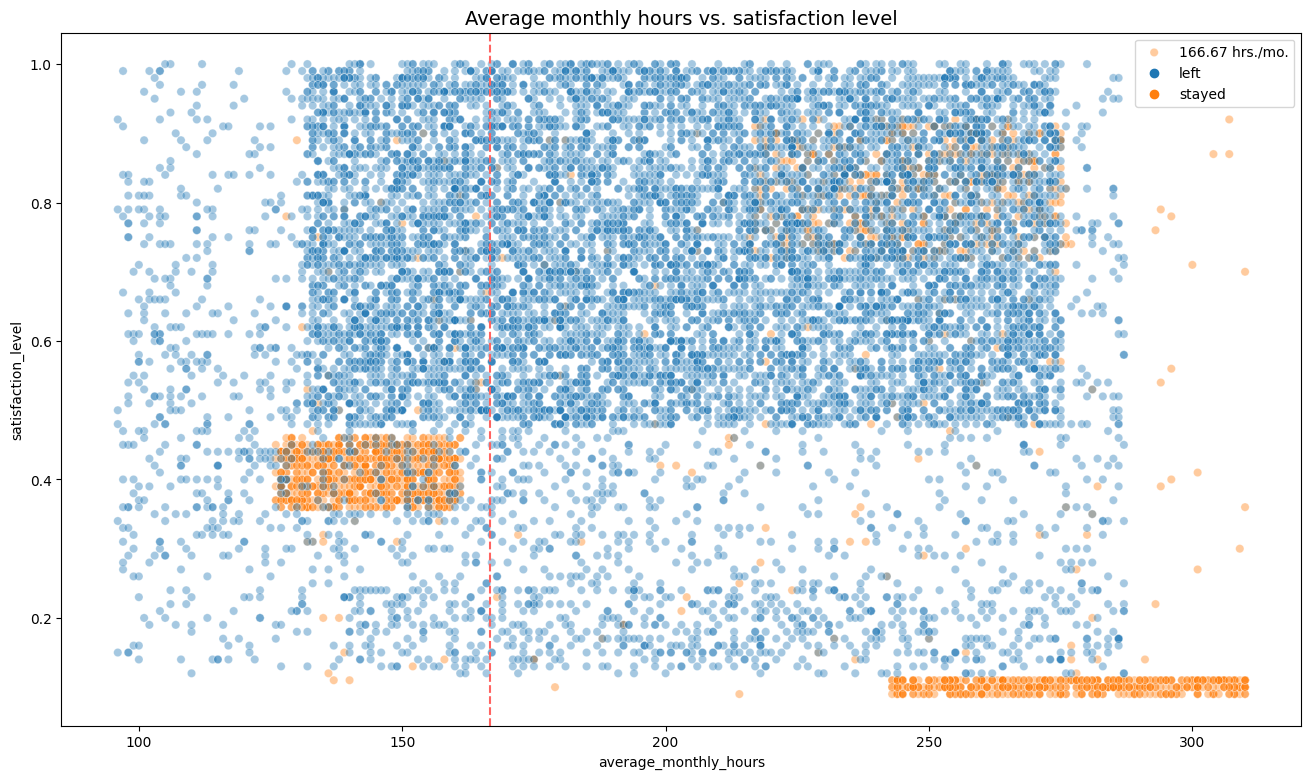

In [141]:
# create a scatterplot of average monthly hours vs. satisfaction level, comparing those who left and those who stayed
plt.figure(figsize=(16,9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.4)
plt.axvline(x=166.7, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Average monthly hours vs. satisfaction level', fontsize=14)

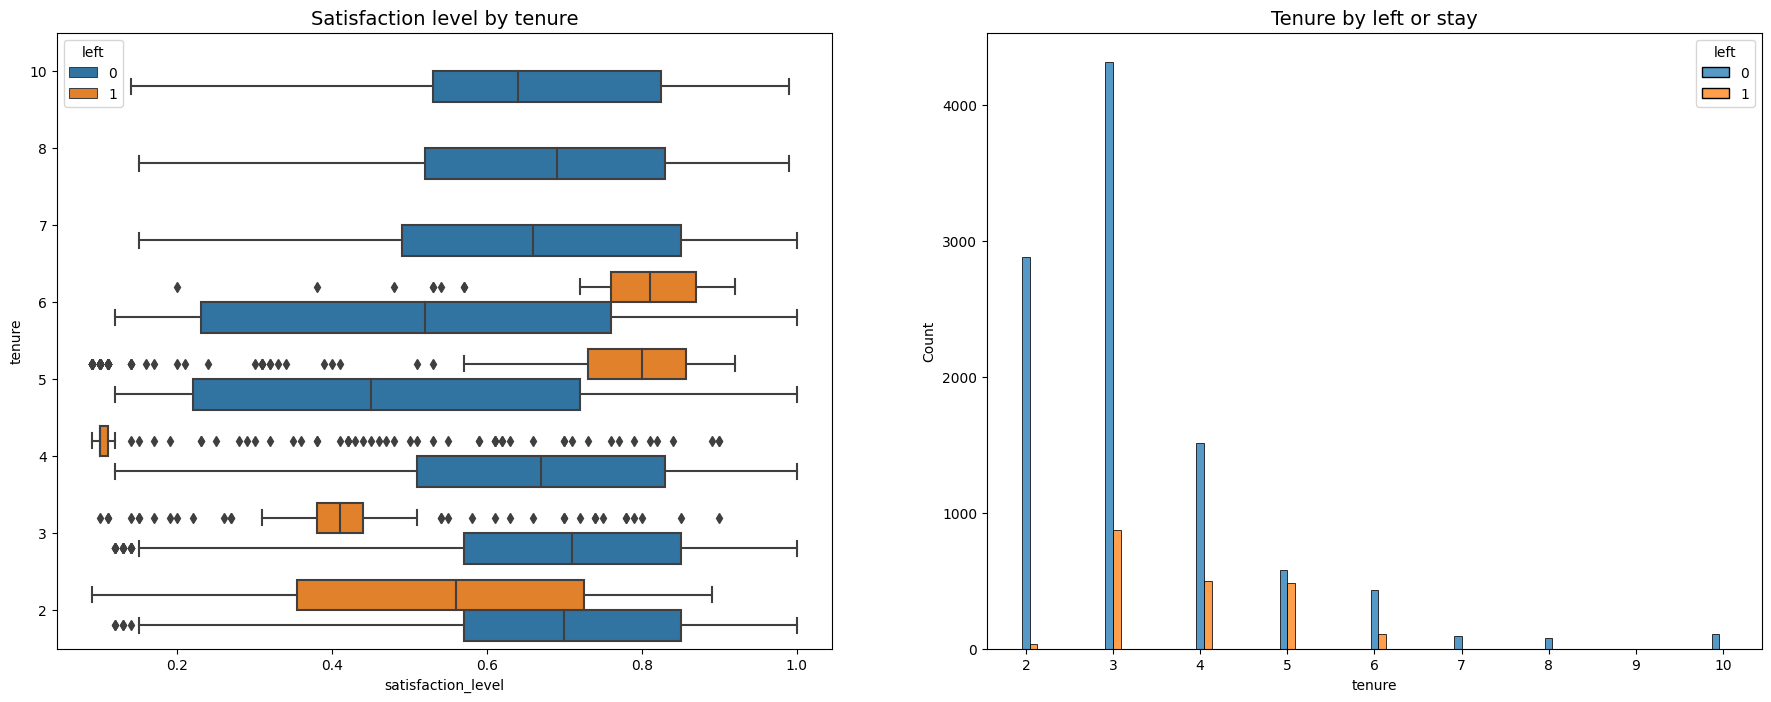

In [142]:
# Next satisfaction level vs. tenure

fig, ax = plt.subplots(1,2, figsize = (22,8))

sns.boxplot(data=df1, x='satisfaction_level', y='tenure', hue='left', orient='h', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction level by tenure', fontsize='14')

tenure_stay = df1[df1['left'] == 0]['tenure']
tenure_left = df1[df1['left'] == 1]['tenure']
sns.histplot(data=df1, x='tenure', hue='left',  multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Tenure by left or stay', fontsize='14')

plt.show()

In [143]:
# calculate the mean and median satisfaction scored of employees who left and those who stayed
df1.groupby('left')['satisfaction_level'].agg(['mean', 'median'])

,mean,median
left,,
0,0.667365,0.69
1,0.440271,0.41


Text(0.5, 1.0, 'Salary histogram by tenure: long-tenured employees')

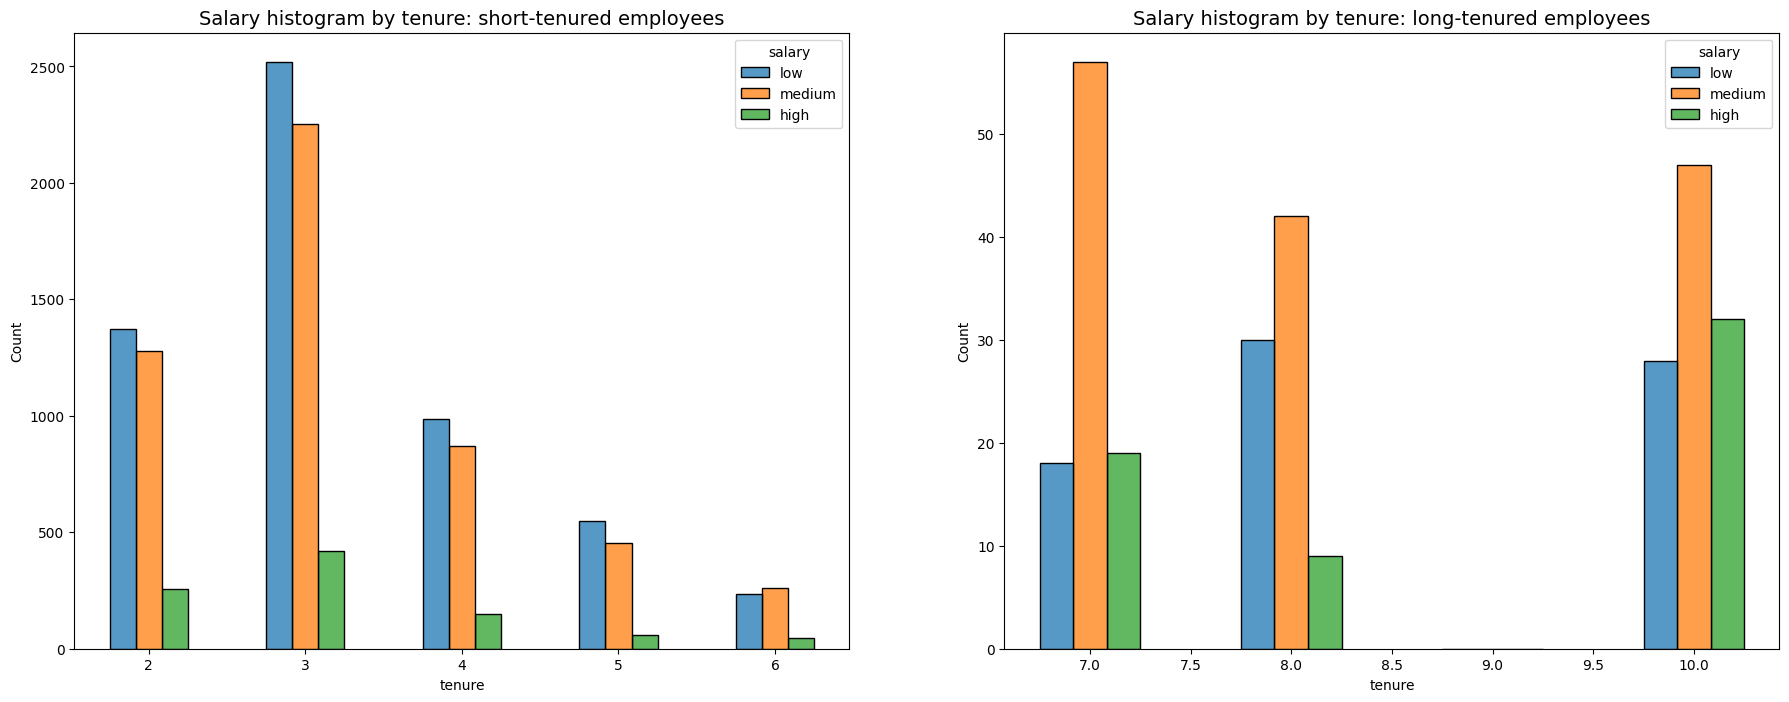

In [144]:
# Examining the salary levels for different tenures
fig, ax = plt.subplots(1,2, figsize = (22,8))

tenure_short = df1[df1['tenure'] < 7]

tenure_long = df1[df1['tenure'] > 6]

sns.histplot(data=tenure_short, x='tenure', hue='salary', discrete=1, hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=0.5, ax=ax[0])
ax[0].set_title('Salary histogram by tenure: short-tenured employees', fontsize='14')

sns.histplot(data=tenure_long, x='tenure', hue='salary', discrete=1, hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=0.5, ax=ax[1])
ax[1].set_title('Salary histogram by tenure: long-tenured employees', fontsize='14')




Text(0.5, 1.0, 'Average monthly hours vs. last evaluation')

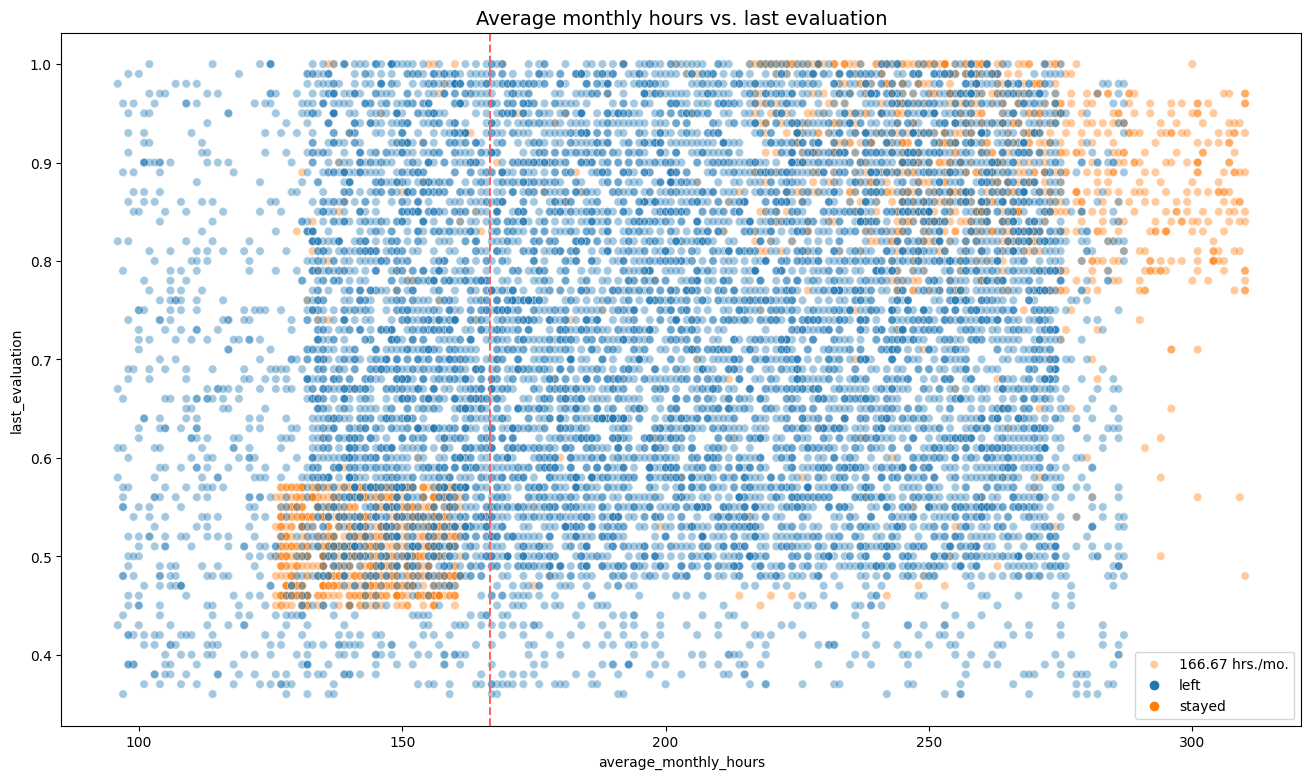

In [145]:
# creating a scatterplot of average monthly hours vs last evaluation
plt.figure(figsize=(16,9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.axvline(x=166.7, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Average monthly hours vs. last evaluation', fontsize=14)

Text(0.5, 1.0, 'Average monthly hours vs. promotion in last 5 years')

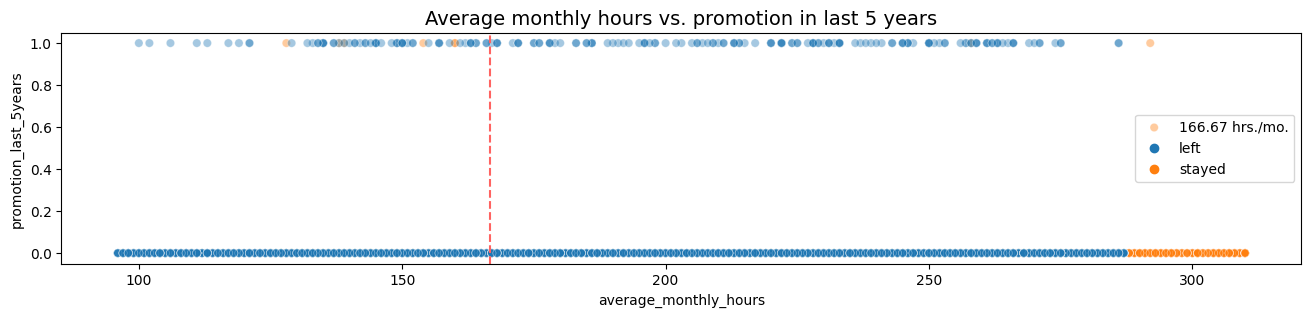

In [146]:
# Examining whether employees who worked very long hours were promoted in laste five years

plt.figure(figsize=(16,3))
sns.scatterplot(data=df1, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.axvline(x=166.7, color='#ff6361', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Average monthly hours vs. promotion in last 5 years', fontsize=14)

Text(0.5, 1.0, 'Distribution of employees who left across departments')

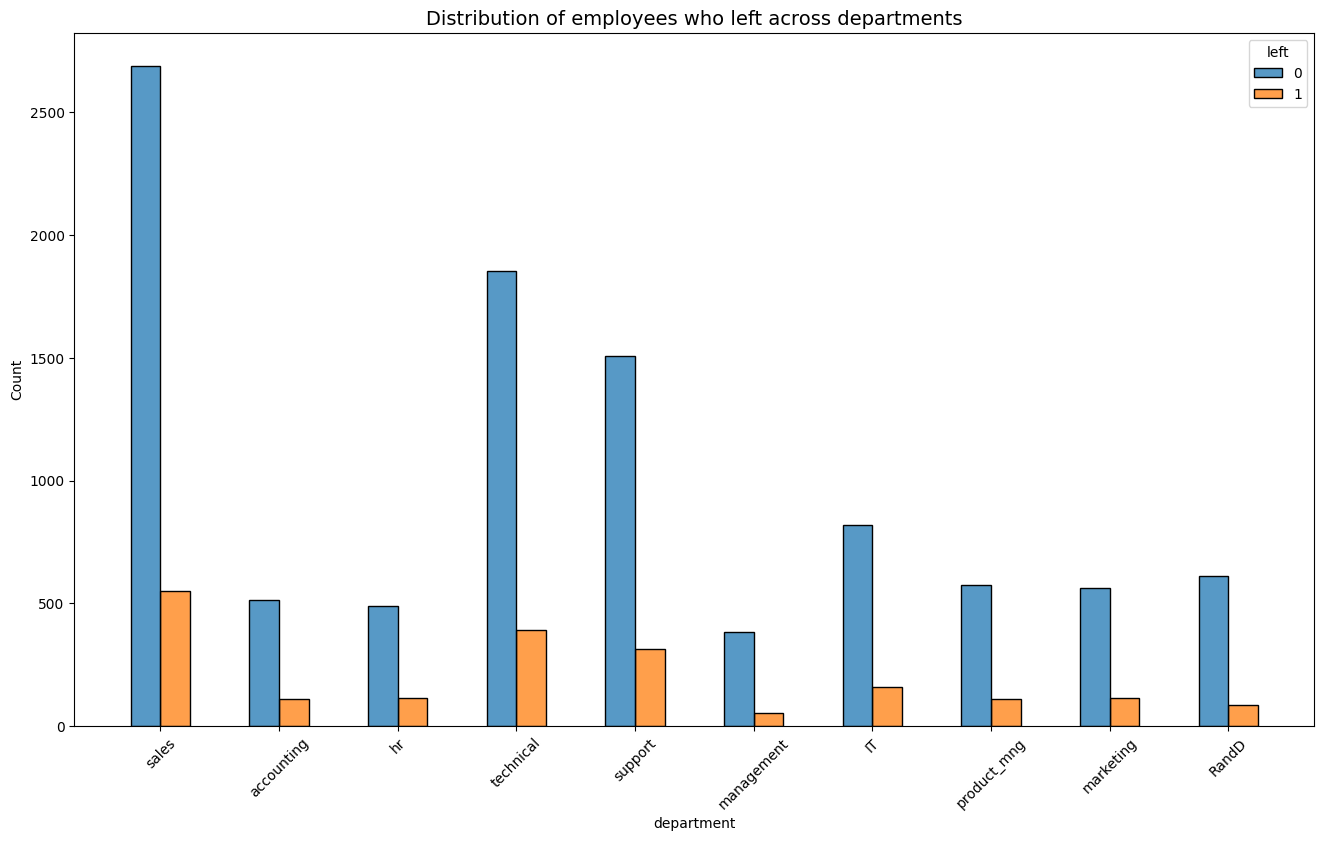

In [147]:
# Distribution of employess who left across the departments
plt.figure(figsize=(16,9))
sns.histplot(data=df1, x='department', hue='left', 
             discrete=1, hue_order=[0,1], multiple='dodge', shrink=0.5)
plt.xticks(rotation=45)
plt.title('Distribution of employees who left across departments', fontsize=14)

In [148]:
df1['salary'].value_counts()

salary
low       5740
medium    5261
high       990
Name: count, dtype: int64

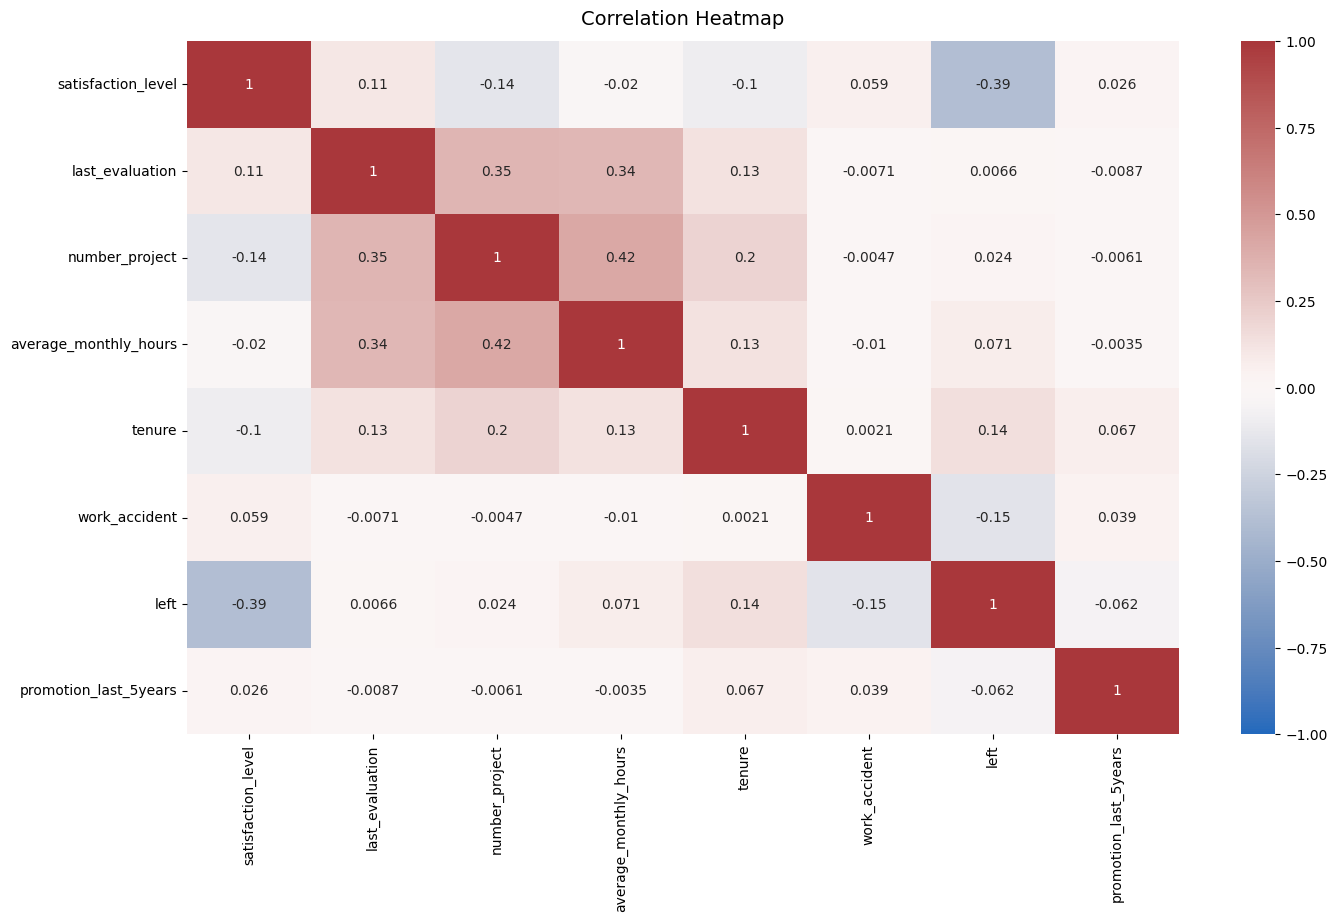

In [149]:
# drop the salary column and department column
df2 = df0.drop(['salary', 'department'], axis=1)

plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df2.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

In [150]:
df_enc = pd.get_dummies(df1, prefix=['salary', 'dept'], columns=['salary', 'department'], drop_first=False)
df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary_high,salary_low,salary_medium,dept_IT,dept_RandD,dept_accounting,dept_hr,dept_management,dept_marketing,dept_product_mng,dept_sales,dept_support,dept_technical
0,0.38,0.53,2,157,3,0,1,0,False,True,False,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,False,False,True,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,False,False,True,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,False,True,False,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,False,True,False,False,False,False,False,False,False,False,True,False,False


In [151]:
# convert the boolean values columns to int64
df_enc['salary_low'] = df_enc['salary_low'].astype('int64') 
df_enc['salary_medium'] = df_enc['salary_medium'].astype('int64')
df_enc['salary_high'] = df_enc['salary_high'].astype('int64')
df_enc['dept_IT'] = df_enc['dept_IT'].astype('int64')
df_enc['dept_RandD'] = df_enc['dept_RandD'].astype('int64')
df_enc['dept_accounting'] = df_enc['dept_accounting'].astype('int64')
df_enc['dept_hr'] = df_enc['dept_hr'].astype('int64')
df_enc['dept_management'] = df_enc['dept_management'].astype('int64')
df_enc['dept_marketing'] = df_enc['dept_marketing'].astype('int64')
df_enc['dept_product_mng'] = df_enc['dept_product_mng'].astype('int64')
df_enc['dept_sales'] = df_enc['dept_sales'].astype('int64')
df_enc['dept_support'] = df_enc['dept_support'].astype('int64')
df_enc['dept_technical'] = df_enc['dept_technical'].astype('int64')
df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary_high,salary_low,salary_medium,dept_IT,dept_RandD,dept_accounting,dept_hr,dept_management,dept_marketing,dept_product_mng,dept_sales,dept_support,dept_technical
0,0.38,0.53,2,157,3,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0


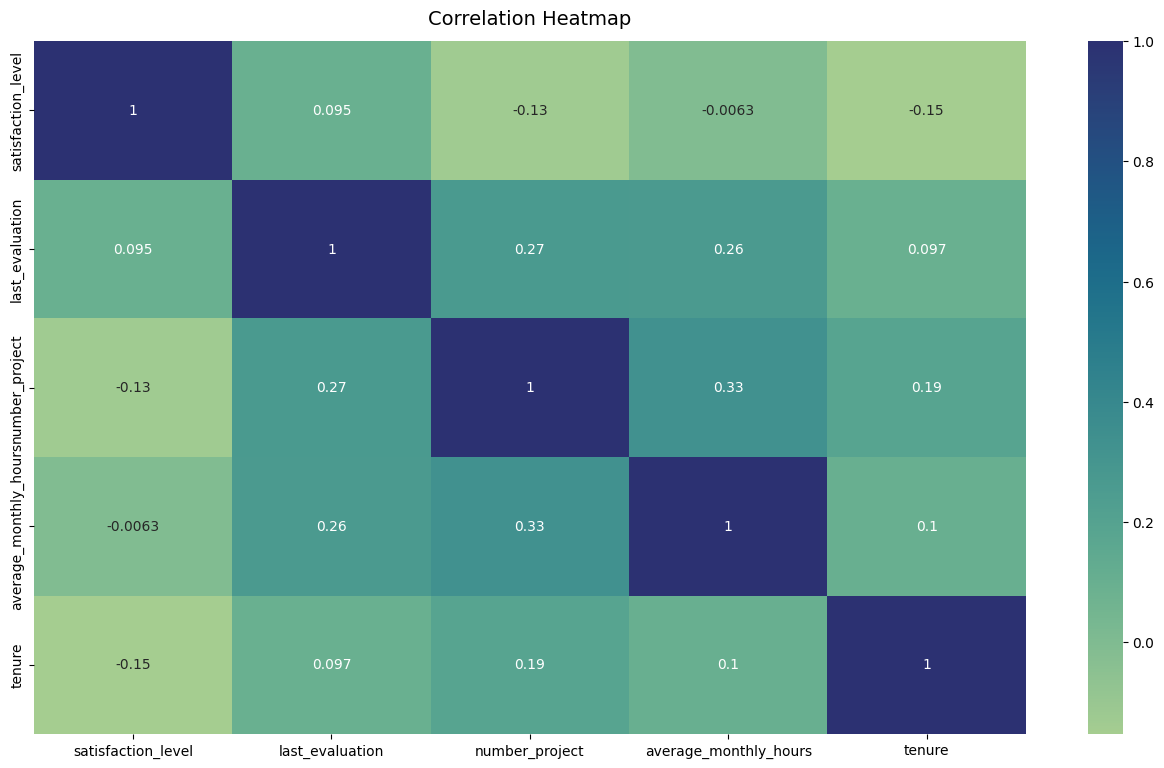

In [152]:
plt.figure(figsize=(16, 9))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']].corr(), annot=True, cmap="crest")
plt.title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);
plt.show()

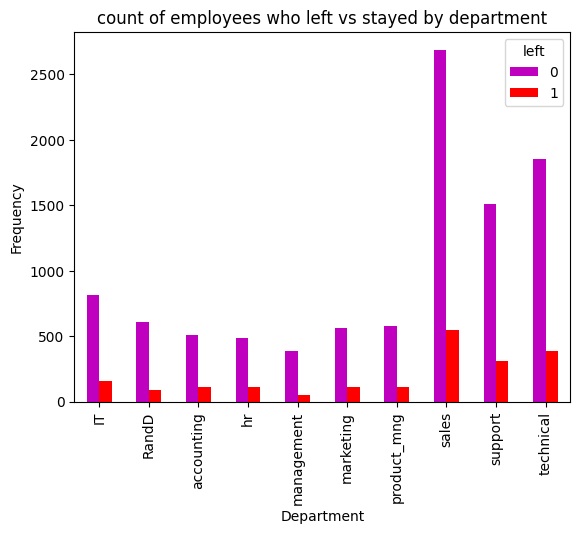

In [153]:
pd.crosstab(df1["department"], df1["left"]).plot(kind="bar", color='mr')
plt.title("count of employees who left vs stayed by department")
plt.xlabel("Department")
plt.ylabel("Frequency")
plt.show()


In [154]:
df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)]
df_logreg.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary_high,salary_low,salary_medium,dept_IT,dept_RandD,dept_accounting,dept_hr,dept_management,dept_marketing,dept_product_mng,dept_sales,dept_support,dept_technical
0,0.38,0.53,2,157,3,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
5,0.41,0.50,2,153,3,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [155]:
df_logreg.count()

satisfaction_level       11167
last_evaluation          11167
number_project           11167
average_monthly_hours    11167
tenure                   11167
work_accident            11167
left                     11167
promotion_last_5years    11167
salary_high              11167
salary_low               11167
salary_medium            11167
dept_IT                  11167
dept_RandD               11167
dept_accounting          11167
dept_hr                  11167
dept_management          11167
dept_marketing           11167
dept_product_mng         11167
dept_sales               11167
dept_support             11167
dept_technical           11167
dtype: int64

In [156]:
# Isolate the target variable
y = df_logreg['left']
y.head()

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

In [161]:
# select the features to be used for the model
X = df_logreg[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure', 'work_accident', 'promotion_last_5years', 'salary_low', 'salary_medium', 'salary_high', 'dept_IT', 'dept_RandD', 'dept_accounting', 'dept_hr', 'dept_management', 'dept_marketing', 'dept_product_mng', 'dept_sales', 'dept_support', 'dept_technical']]
x.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary_low,salary_medium,salary_high,dept_IT,dept_RandD,dept_accounting,dept_hr,dept_management,dept_marketing,dept_product_mng,dept_sales,dept_support,dept_technical
0,0.38,0.53,2,157,3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
5,0.41,0.50,2,153,3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [162]:
from sklearn.model_selection import train_test_split

In [164]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


In [165]:
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

In [166]:
y_pred = log_clf.predict(X_test)

In [167]:
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

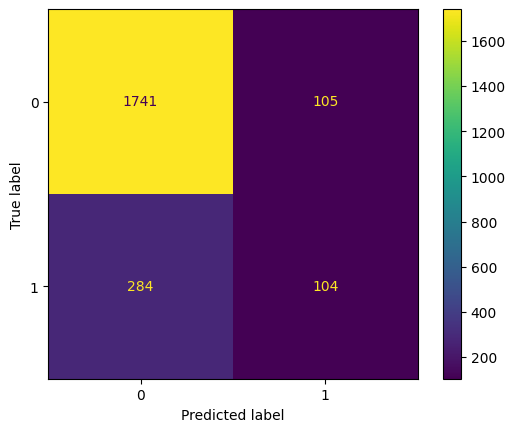

In [169]:
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)
log_disp.plot()
plt.show()

In [170]:
df_logreg['left'].value_counts(normalize=True)

left
0    0.831468
1    0.168532
Name: proportion, dtype: float64

In [171]:
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.94      0.90      1846
    Predicted would leave       0.50      0.27      0.35       388

                 accuracy                           0.83      2234
                macro avg       0.68      0.61      0.62      2234
             weighted avg       0.80      0.83      0.80      2234



### Summary of model results

**Logistic Regression**

The logistic regression model achieved precision of 80%, recall of 83%, f1-score of 80% (all weighted averages), and accuracy of 83%, on the test set.

### Conclusion, Recommendations, Next Steps

The models and the feature importances extracted from the models confirm that employees at the company are overworked. 

To retain employees, the following recommendations could be presented to the stakeholders:

* Cap the number of projects that employees can work on.
* Consider promoting employees who have been with the company for atleast four years, or conduct further investigation about why four-year tenured employees are so dissatisfied. 
* Either reward employees for working longer hours, or don't require them to do so. 
* If employees aren't familiar with the company's overtime pay policies, inform them about this. If the expectations around workload and time off aren't explicit, make them clear. 
* Hold company-wide and within-team discussions to understand and address the company work culture, across the board and in specific contexts. 
* High evaluation scores should not be reserved for employees who work 200+ hours per month. Consider a proportionate scale for rewarding employees who contribute more/put in more effort. 

**Next Steps**

It may be justified to still have some concern about data leakage. It could be prudent to consider how predictions change when `last_evaluation` is removed from the data. It's possible that evaluations aren't performed very frequently, in which case it would be useful to be able to predict employee retention without this feature. It's also possible that the evaluation score determines whether an employee leaves or stays, in which case it could be useful to pivot and try to predict performance score. The same could be said for satisfaction score. 